In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import metrics
import math
from transformers import pipeline
import torch
import json
import ollama
import csv
import time
import seaborn as sns

In [2]:
df = pd.read_csv('filtered_data_equalRating_dist.csv')
print(df.shape)
df.drop(columns=["user_id", "review_id", "book_id"], inplace=True)
df = df.dropna(subset=['review_text'])
df["review_text"] = df["review_text"].astype(str)
df

(40000, 12)


,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,type
0,4,Fun sequel to the original.,Tue Nov 17 11:37:35 -0800 2015,Tue Nov 17 11:38:05 -0800 2015,NaN,NaN,7,0,children
1,5,One of my favorite books to read to my 5 year ...,Sat Nov 08 08:54:03 -0800 2014,Wed Jan 25 13:56:12 -0800 2017,Tue Jan 24 00:00:00 -0800 2017,NaN,4,0,children
2,0,A friend of Elizabeth's I met at a party said ...,Sun Dec 17 14:27:30 -0800 2006,Thu Jul 31 00:32:08 -0700 2014,NaN,NaN,2,1,children
3,2,"I'm getting bored...it's the same book, over a...",Wed Jul 06 10:05:12 -0700 2016,Wed Jul 06 10:07:38 -0700 2016,Wed Jun 01 00:00:00 -0700 2016,NaN,0,0,children
4,3,"I want to love these books so much, because I ...",Tue Sep 22 10:18:57 -0700 2015,Mon Sep 28 10:12:37 -0700 2015,Fri Sep 25 00:00:00 -0700 2015,Tue Sep 22 00:00:00 -0700 2015,0,0,children
...,...,...,...,...,...,...,...,...,...
39995,3,I wanted to like this one. I really did. \n Bu...,Mon May 18 10:39:45 -0700 2015,Thu Oct 01 10:22:50 -0700 2015,Thu Oct 01 10:22:50 -0700 2015,Mon Aug 31 00:00:00 -0700 2015,0,0,young_adult
39996,2,"Not really my thing, but it wasn't terrible. S...",Sun Jun 22 16:10:20 -0700 2014,Wed Jul 02 22:58:56 -0700 2014,Sun Jun 22 22:48:03 -0700 2014,Sun Jun 22 00:00:00 -0700 2014,0,0,young_adult
39997,1,boring,Fri Aug 24 21:42:00 -0700 2012,Fri Oct 05 21:18:53 -0700 2012,Fri Oct 05 00:00:00 -0700 2012,Tue Aug 28 00:00:00 -0700 2012,1,0,young_adult
39998,2,Good story. Really not incredibly romantic lik...,Fri Aug 24 21:32:00 -0700 2012,Tue Jun 02 10:51:10 -0700 2015,Fri Oct 05 00:00:00 -0700 2012,Wed Sep 26 00:00:00 -0700 2012,0,0,young_adult


In [3]:
df.dtypes

rating           int64
review_text     object
date_added      object
date_updated    object
read_at         object
started_at      object
n_votes          int64
n_comments       int64
type            object
dtype: object

In [11]:
num_rows = df.shape[0]
num_cols = df.shape[1]
print(f'The number of rows in the DataFrame is: {num_rows}')
print(f'The number of columns in the DataFrame is: {num_cols}')

The number of rows in the DataFrame is: 39959
The number of columns in the DataFrame is: 9


# Trying classification of the rating using ollama with LLM Llama 3.2

Inspired by [Text Classification with Large Language Models (LLMs)](https://hussainpoonawala.medium.com/text-classification-with-large-language-models-llms-a23c731a687e) by Hussain Poonawala.

In [4]:
i = 4084
n_trues = 0
n_falses = 0

# Split the dataframe into 5 for each rating with 20 of each
# dfs = []
# for rating in range(0, 6):
#     dfs.append(df[df['rating'] == rating].sample(n=1500, random_state=1))
# df_sampled = pd.concat(dfs).reset_index(drop=True)

df_sampled = pd.read_csv('sampled_data.csv')
# Open a CSV file to write the JSON output
with open('predicted_ratings.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Real Rating', 'Predicted Rating', 'Assertion', 'Audit Reasons', 'Iteration', 'StartTime', 'EndTime', 'Duration'])

    while i <= 9010:
        # Record the start time
        start_time = time.time()
        review_text = df_sampled.iloc[i]['review_text']
        
        prompt = f"""
            You are tasked with classifying a book review based on a human's rating on a scale of 0 to 5, reflecting their overall satisfaction with the book. The review is the following: "{review_text}".
            The review was posted on an online book reviewing platform. Use the following criteria to guide your classification:
            **Rating Scale**:
            1. 0 - Really Bad
            1. 1 - Very Bad
            2. 2 - Bad
            3. 3 - Average
            4. 4 - Good
            5. 5 - Very Good

            **Guidelines**:
            1. Read the review carefully, paying attention to both the explicit content and implied sentiments.
            2. Think like a human reviewer and infer the overall impression and satisfaction level of the user from the text.
            3. Avoid simple keyword matching or sentiment analysis. Instead, consider the deeper meaning and tone of the review.
            
            **Key Aspects to Consider**:
            - **Sentiment**: Is the overall tone positive, negative, or neutral?
            - **Engagement**: Does the reviewer seem deeply involved with the book or detached and indifferent?
            - **Plot and Character Satisfaction**: Are there complaints about the plot or characters that indicate dissatisfaction, or praise that suggests satisfaction?
            - **Recommendation Willingness**: Does the reviewer express a desire to recommend the book to others, or show reluctance?

            **Audit Reason Categories**:
            You must select one reason that justifies your classification, using the following categories:
            1. Positive Sentiment
            2. Negative Sentiment
            3. Neutral Sentiment
            4. Plot Dissatisfaction
            5. Character Dissatisfaction
            6. Lack of Engagement
            7. Recommendation Hesitation
            8. Pacing Issues
            9. Repetition (Feeling of Deja Vu)
            10. General Enjoyment

            **DOs**:
            1. Be specific and clear in your audit reasoning.
            2. Think like a human reviewer, understanding the overall impression, tone, and the context of the book being reviewed.
            3. Consider nuanced factors like pacing, emotional engagement, and depth of plot/character development.
            4. Use the Output Format provided below to structure your response.
            
            **DON'Ts**:
            1. Do not rely purely on word choices for classification.
            2. Avoid guesses or assumptions. Base your classification solely on the review content provided.
            3. Do not repeat the same audit reasons unless strongly justified by the review.
            4. Do not add any additional information before or after the Output Format, i really just want to see the json output.
            5. Do not include any extra characters in the output.

            **Output Format**:
            {{
            "predictedRating": "",
            "auditReasons": [],
            "reason": ""
            }}

            Examples:

            1. Review: 'One of my favorite books to read to my 5-year-old. Beautifully written and keeps them engaged the whole time.'
            Output: {{ predictedRating: "5", auditReasons: ['Positive Sentiment'], "reason": "The reviewer expresses clear satisfaction." }}

            2. Review: 'Fun sequel to the original, but not quite as captivating.'
            Output: {{ predictedRating: "4", auditReasons: ['Positive Sentiment'], "reason": "Generally positive but less engaging." }}

            3. Review: 'I'm getting bored... it's the same book, over and over again. But now I'm invested in finding out what happens to these children.'
            Output: {{ predictedRating: "2", auditReasons: ['Negative Sentiment'], "reason": "Dissatisfaction with repetition." }}

            4. Review: 'The characters were well-written, but the pacing was just too slow. Took me a long time to finish.'
            Output: {{ predictedRating: "3", auditReasons: ['Neutral Sentiment'], "reason": "Mixed feelings about pacing." }}

            5. Review: 'I wanted to love it, but the plot was too predictable. I wouldn't recommend it to others.'
            Output: {{ predictedRating: "2", auditReasons: ['Negative Sentiment'], "reason": "Disappointment with predictable plot." }}
            
            6. Review: 'Huh, loppuipa vihdoin. Lopun paljastus siita, etta Narnia onkin taivas, ei ollut todellakaan mikaan yllatys. Kokonaisuudessaan Narnia ei tosiaan ole kirjasarja omaan makuuni ja luulen, etta jos olisin lukenut kirjat nuorempana, olisi suhtautuminen varmaan toinen. Nyt, ateistina, liian paalleliimattu kristillisyys arsytti, samoin Aslanin hahmo. Aikarakenteen muuttuminen kirjasta toiseen oli vahan omituinen ratkaisu, tosin kirjat olisi voinut myos lukea kronologisessa jarjestyksessa... Juonet kirjoissa olivat aika suoraviivaisia (ehka viimeista kirjaa lukuunottamatta) ja satumaisia, hahmot yksiulotteisia ja aika yhdentekevia. Maailman kuvaus toimi hyvin, mutta motiivien ja syiden kertominen ei. Aika yhdentekevia kirjoja minulle.'
            Output: {{ predictedRating: "1", auditReasons: ['Negative Sentiment'], "reason": "Strong dissatisfaction with plot and characters." }}
            
            7. Review: 'I really don't like this book. It makes it seem like the baby's interactions are almost exclusively through social media. Plus, the illustrations are not very inspiring.'
            Output: {{ predictedRating: "1", auditReasons: ['Negative Sentiment'], "reason": "Strong dissatisfaction with plot and characters." }}
            
            Please follow the guidelines strictly and classify based on the full context of the review.
            """
        response = ollama.generate(model='llama3.2:latest', prompt=prompt, format="json", options=ollama.Options(timeout=360000))["response"]
        # Parse the response into JSON string
        try:
            parsed_json_response = json.loads(response)
        except json.JSONDecodeError as e:
            continue
        # Accessing the parsed JSON data
        predicted_rating = parsed_json_response["predictedRating"]
        audit_reasons = parsed_json_response["auditReasons"]
        # reason = parsed_json_response["reason"]
        real_rating = df_sampled.iloc[i]['rating']
        try:
            assertion = real_rating == int(predicted_rating)
        except ValueError as e:
            print(f"Error converting predicted rating to int: {e}")
            continue
        print(f"Real Rating: {real_rating}, Predicted Rating: {predicted_rating}, Assertion: {assertion}")
        
        # Record the end time
        end_time = time.time()
        duration = end_time - start_time
        
        n_trues += 1 if assertion else 0
        n_falses += 1 if not assertion else 0
        
        print("Percentage of True Predictions: ", n_trues / (n_trues + n_falses) * 100)
        
        # Write the data to the CSV file
        writer.writerow([real_rating, predicted_rating, assertion, audit_reasons, i, start_time, end_time, duration])
        file.flush()  # Ensure data is written to the file at each iteration
        
        i += 1

Real Rating: 2, Predicted Rating: 2, Assertion: True
Percentage of True Predictions:  100.0
Real Rating: 2, Predicted Rating: 0, Assertion: False
Percentage of True Predictions:  50.0
Real Rating: 2, Predicted Rating: 2, Assertion: True
Percentage of True Predictions:  66.66666666666666
Real Rating: 2, Predicted Rating: 2, Assertion: True
Percentage of True Predictions:  75.0
Real Rating: 2, Predicted Rating: 3, Assertion: False
Percentage of True Predictions:  60.0
Real Rating: 2, Predicted Rating: 2, Assertion: True
Percentage of True Predictions:  66.66666666666666
Real Rating: 2, Predicted Rating: 1, Assertion: False
Percentage of True Predictions:  57.14285714285714
Real Rating: 2, Predicted Rating: 3, Assertion: False
Percentage of True Predictions:  50.0
Real Rating: 2, Predicted Rating: 3, Assertion: False
Percentage of True Predictions:  44.44444444444444
Real Rating: 2, Predicted Rating: 4, Assertion: False
Percentage of True Predictions:  40.0
Real Rating: 2, Predicted Ratin

IndexError: single positional indexer is out-of-bounds

In [12]:
# from sklearn.metrics import confusion_matrix, classification_report

# # Load the predicted ratings
# df_predicted = pd.read_csv('predicted_ratings_20Eachs_99.csv')

# # Extract the real and predicted ratings
# y_true = df_predicted['Real Rating']
# y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# # Create the confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Display the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
# plt.xlabel('Predicted Rating')
# plt.ylabel('True Rating')
# plt.title('Confusion Matrix')
# plt.show()

# # Calculate and print classification report
# report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(1, 6)], output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# df_report

In [13]:
df_sampled.to_csv("sampled_data.csv", index=False)

In [10]:
# # Read the CSV files
# df_1 = pd.read_csv('predicted_ratings_0_4083.csv')
# df_2 = pd.read_csv('predicted_ratings.4083_final.csv')

# # Concatenate the dataframes
# df_combined = pd.concat([df_1, df_2], ignore_index=True)

# # Save the combined dataframe to a new CSV file
# df_combined.to_csv('combined_predicted_ratings.csv', index=False)

# Evalutation of the LLM model for rating prediction

### Without the 0 rating

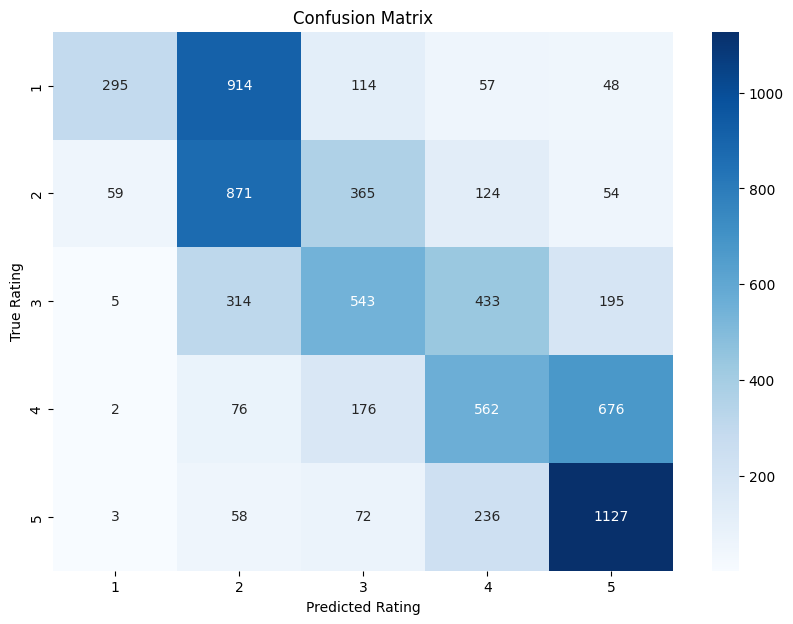

,precision,recall,f1-score,support
1,0.810440,0.206583,0.329241,1428.000000
2,0.390058,0.591310,0.470049,1473.000000
3,0.427559,0.364430,0.393478,1490.000000
4,0.398017,0.376676,0.387052,1492.000000
5,0.536667,0.753342,0.626808,1496.000000
accuracy,0.460496,0.460496,0.460496,0.460496
macro avg,0.512548,0.458468,0.441326,7379.000000
weighted avg,0.510316,0.460496,0.442337,7379.000000


In [3]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the predicted ratings
df_predicted = pd.read_csv('combined_predicted_ratings.csv')
df_predicted = df_predicted[(df_predicted["Real Rating"] != 0) & (df_predicted["Predicted Rating"] != 0)]

# Extract the real and predicted ratings
y_true = df_predicted['Real Rating']
y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(1, 6)], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

### Including the 0 rating

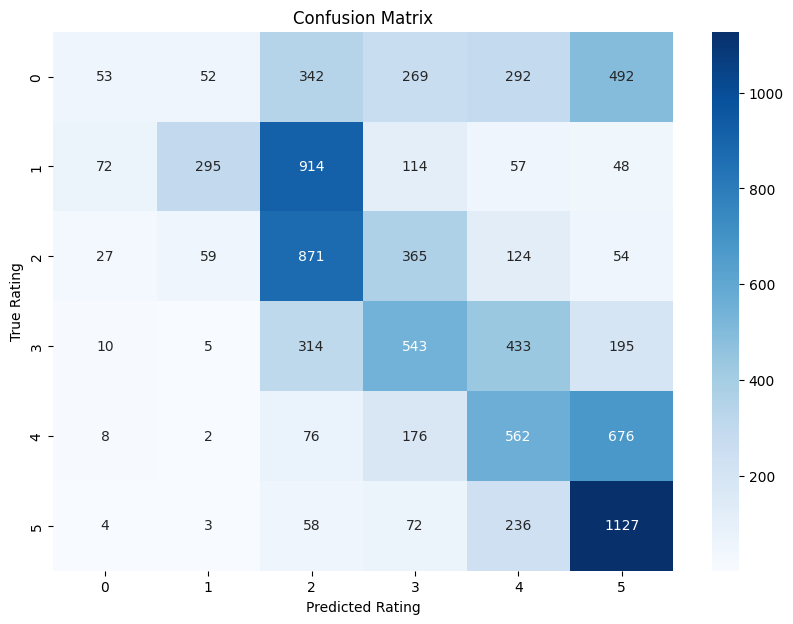

,precision,recall,f1-score,support
0,0.304598,0.035333,0.063321,1500.000000
1,0.709135,0.196667,0.307933,1500.000000
2,0.338252,0.580667,0.427485,1500.000000
3,0.352827,0.362000,0.357354,1500.000000
4,0.329812,0.374667,0.350811,1500.000000
5,0.434799,0.751333,0.550831,1500.000000
accuracy,0.383444,0.383444,0.383444,0.383444
macro avg,0.411570,0.383444,0.342956,9000.000000
weighted avg,0.411570,0.383444,0.342956,9000.000000


In [6]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the predicted ratings
df_predicted = pd.read_csv('combined_predicted_ratings.csv')

# Extract the real and predicted ratings
y_true = df_predicted['Real Rating']
y_pred = df_predicted['Predicted Rating'].astype(int)  # Ensure the predicted ratings are integers

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(0, 6)], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report